Riley Estes
EE399 HW3
4/19/2023

Github link:
https://github.com/rileywe/PCA-and-classification-of-MNIST-data

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import mpl_toolkits
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784')

x:\anaconda\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X = mnist.data
Y = mnist.target.astype(int)
print(np.shape(X))
print(np.shape(Y))

(70000, 784)
(70000,)


In [4]:
#Calculates SVD for the MNIST data
u, s, vt = np.linalg.svd(X, full_matrices=False)

In [5]:
print("u shape:", u.shape)
print("s shape:", s.shape)
print("vt shape:", vt.shape)
print(s[0])

u shape: (70000, 784)
s shape: (784,)
vt shape: (784, 784)
417574.1046588142


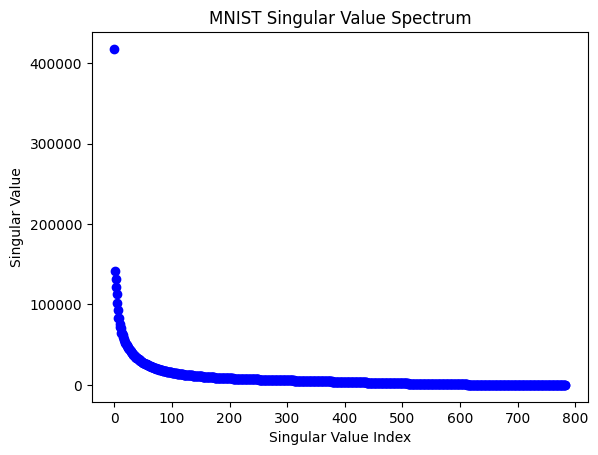

In [6]:
#Plots the singular values from the SVD
plt.plot(s, 'bo')
plt.title('MNIST Singular Value Spectrum')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.show()

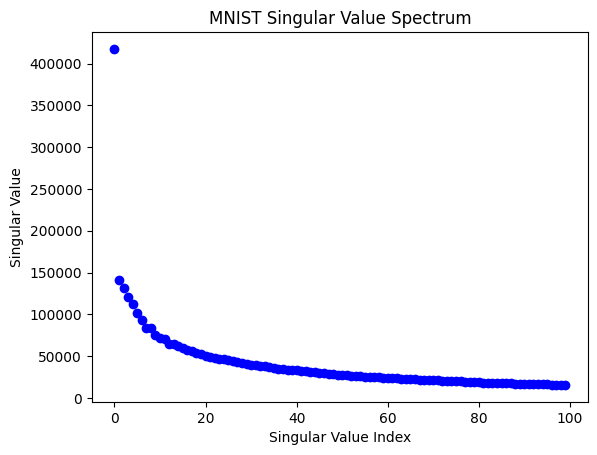

In [7]:
#Shows the elbow point to be around 10 to 30
plt.plot(s[0:100], 'bo')
plt.title('MNIST Singular Value Spectrum')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.show()

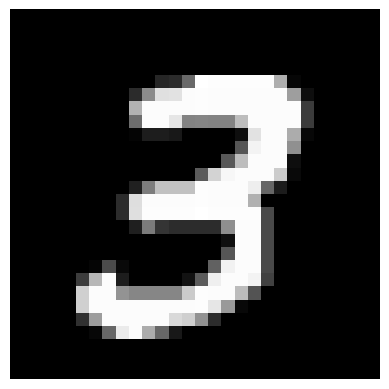

In [8]:
#Creates a numpy array for the MNIST data X
Xnp = np.array(X)
#plots one of the numbers in the dataset for reference
plt.imshow(Xnp[7, :].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

In [9]:
#Takes an image index, number of singular values to reconstruct with, and the SVD output matrices to reconstruct an image
#using the top k singular values from the SVD
def kPrint (img, k, u, s, vt):
    #use the top k singlar vectors
    u_k = u[:, :k]
    s_k = s[:k]
    vt_k = vt[:k, :]

    # Reconstruct the images using the truncated matrix factors
    X_reconstructed = np.dot(u_k, np.dot(np.diag(s_k), vt_k))

    #graph the reconstructed image
    plt.imshow(X_reconstructed[img, :].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

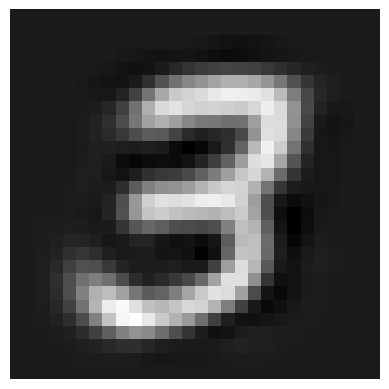

In [10]:
# Truncate the SVD to keep only the first 50 singular values
kPrint(7, 50, u, s, vt)

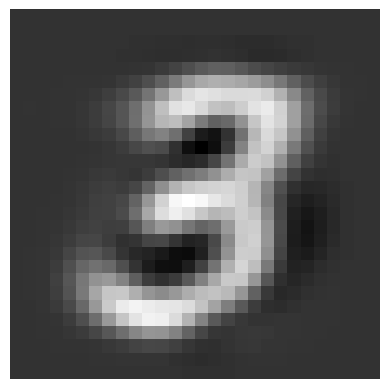

In [11]:
# Truncate the SVD to keep only the first 20 singular values
kPrint(7, 20, u, s, vt)

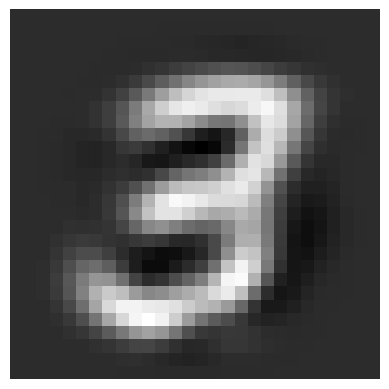

In [12]:
# Truncate the SVD to keep only the first 30 singular values
kPrint(7, 30, u, s, vt)

The rank r of the dataset is about 30. This is about the point where the image can be just well enough constructed to be crisp and clear. A rank of 10 should also work enough to differentiate the images though not as clearly and possibly less accurately.

The U matrix corresponds to the left singular vectors, or the eigenvectors from XX^T. The V matrix (often outputted at V^T) corresponds to the eigenvectors from (X^T)X. These two matrices are orthogonal to each other and consist of vectors of unit length. The Sigma or s matrix in the middle corresponds to the eigenvalue or singular values for each singular vector, which represent how important each mode is in capturing the variance of the data in order to reconstruct it. The left singular vectors in U capture the most important patterns in the data, and the right singular vectors in V show how these patterns are expressed in the original data set X.

In [13]:
#Takes 3 V-modes, a vt matrix, an X data matrix (with images as rows), a 1D Y labels matrix, and a matrix of all the digits you want to plot
#Prints out X projected into those 3 modes in vt color coded based on its label in Y
def print3D (modes, vt, X, Y, digits):
    #print(np.shape(vt))
    VModes = vt[modes, :]
    #print("Shape of X (MNIST data): ", np.shape(X))
    #print("Shape of VModes: ", np.shape(VModes))
    XProj = np.dot(X, VModes.T)

    #print("Shape of X projected into 3 modes: ", np.shape(XProj))
    #print("Shape of labels array for MNIST data: ", np.shape(Y))

    # Plot in 3D with color coding
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for digit in digits:
        mask = (Y == digit)
        ax.scatter(XProj[mask, 0], XProj[mask, 1], XProj[mask, 2], label=str(digit))
    ax.legend()
    ax.set_xlabel('Mode ' + str(modes[0]))
    ax.set_ylabel('Mode ' + str(modes[1]))
    ax.set_zlabel('Mode ' + str(modes[2]))
    plt.show()


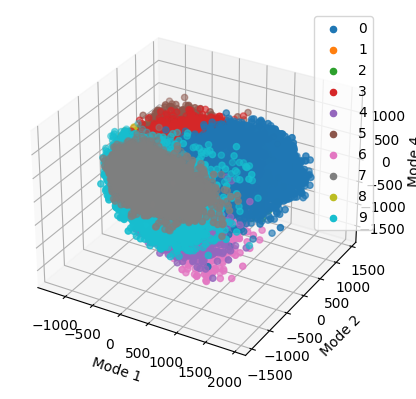

In [14]:
allDigits = np.arange(0, 10, 1)
print3D([1, 2, 4], vt, X, Y, allDigits)

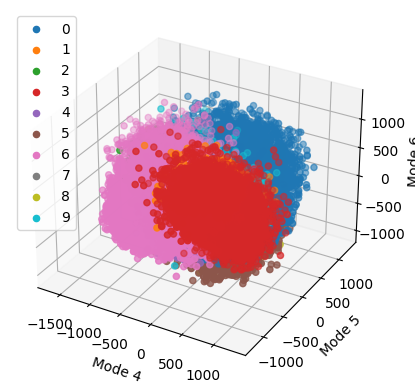

In [15]:
print3D([4, 5, 6], vt, X, Y, allDigits)

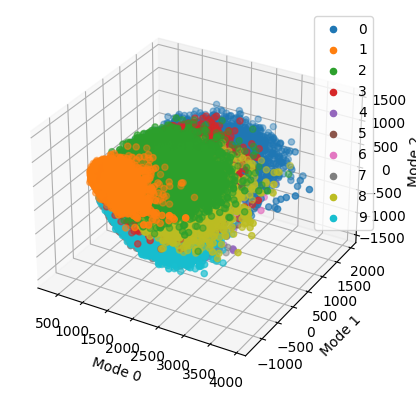

In [16]:
#The next three plots are the same modes but in different orders to see the scatter from different perspectives
print3D([0, 1, 2], vt, X, Y, allDigits)

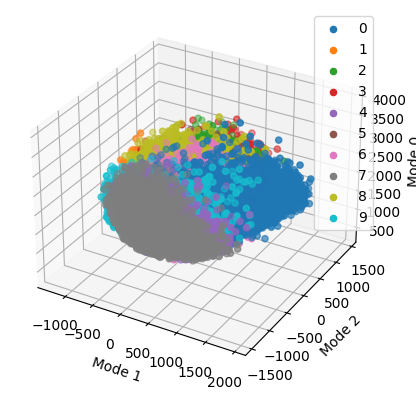

In [17]:
print3D([1, 2, 0], vt, X, Y, allDigits)

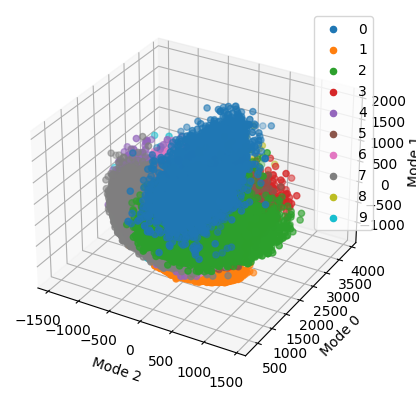

In [18]:
print3D([2, 0, 1], vt, X, Y, allDigits)

In [19]:
#creates empty arrays to append to
resultTrainErrorsTemp = np.empty(0)
resultTestErrorsTemp = np.empty(0)
resultLabelsTemp = np.empty(0)

# Loop over all pairs of digits
for i in range(10):
    for j in range(i + 1, 10):
        #Takes out all of the images in the MNIST set corresponding to the two selected digits
        idx = np.concatenate((np.array(np.where(Y == i))[0, :], np.array(np.where(Y == j))[0, :]))
        X_pair = Xnp[idx]
        #Gets the corresponding labels and sets them to 0 or 1 to more easily classify the digits
        y_pair = Y[idx]
        y_pair[y_pair == i] = 0
        y_pair[y_pair == j] = 1

        #Splits the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_pair, y_pair, test_size=0.2, random_state=0)

        #Trains the LDA classifier
        clf = LinearDiscriminantAnalysis()
        clf.fit(X_train, y_train)

        #Makes predictions on the test and train set
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)

        #Computes the confusion matrix and accuracy
        cmTrain = confusion_matrix(y_train, y_pred_train)
        error_rate_train = 1 - (1 - np.sum(np.diag(cmTrain)) / np.sum(cmTrain))
        cmTest = confusion_matrix(y_test, y_pred_test)
        error_rate_test = 1 - (1 - np.sum(np.diag(cmTest)) / np.sum(cmTest))


        print("Digits {} and {}: test accuracy percentage = {:.4f}, train accuracy percentage = {:.4f}".format(i, j, error_rate_test*100, error_rate_train*100))

        resultTrainErrorsTemp = np.append(resultTrainErrorsTemp, np.array([error_rate_train*100]), axis = 0)
        resultTestErrorsTemp = np.append(resultTestErrorsTemp, np.array([error_rate_test*100]), axis = 0)
        resultLabelsTemp = np.append(resultLabelsTemp, [int(i), int(j)])
resultLabelsTemp = resultLabelsTemp.reshape((-1, 2))

Digits 0 and 1: test accuracy percentage = 99.2219, train accuracy percentage = 99.4841
Digits 0 and 2: test accuracy percentage = 98.0209, train accuracy percentage = 98.8843
Digits 0 and 3: test accuracy percentage = 99.2524, train accuracy percentage = 99.3947
Digits 0 and 4: test accuracy percentage = 99.2717, train accuracy percentage = 99.6722
Digits 0 and 5: test accuracy percentage = 98.6384, train accuracy percentage = 98.7893
Digits 0 and 6: test accuracy percentage = 98.6212, train accuracy percentage = 99.2561
Digits 0 and 7: test accuracy percentage = 99.6831, train accuracy percentage = 99.6742
Digits 0 and 8: test accuracy percentage = 98.6890, train accuracy percentage = 98.8527
Digits 0 and 9: test accuracy percentage = 99.5312, train accuracy percentage = 99.3957
Digits 1 and 2: test accuracy percentage = 97.6799, train accuracy percentage = 98.8144
Digits 1 and 3: test accuracy percentage = 98.5020, train accuracy percentage = 98.9928
Digits 1 and 4: test accuracy pe

In [20]:
#Sorts the errors from best accuracy to worst and prints the sorted results
resultLabels = resultLabelsTemp[np.flip(np.argsort(resultTestErrorsTemp))]
resultTestErrors = resultTestErrorsTemp[np.flip(np.argsort(resultTestErrorsTemp))]
resultTrainErrors = resultTrainErrorsTemp[np.flip(np.argsort(resultTestErrorsTemp))]
print("Sorted errors:")
for i in range(len(resultTestErrors)):
    print(i+1, ": Digit pair ", resultLabels[i], " with test accuracy percentage ", resultTestErrors[i], " and train accuracy percentage ", resultTrainErrors[i])

Sorted errors:
1 : Digit pair  [6. 7.]  with test accuracy percentage  99.7529992942837  and train accuracy percentage  99.85002205558006
2 : Digit pair  [0. 7.]  with test accuracy percentage  99.6830985915493  and train accuracy percentage  99.67418104966538
3 : Digit pair  [0. 9.]  with test accuracy percentage  99.5311936530833  and train accuracy percentage  99.39574314574314
4 : Digit pair  [1. 6.]  with test accuracy percentage  99.52558454761098  and train accuracy percentage  99.644128113879
5 : Digit pair  [6. 9.]  with test accuracy percentage  99.49403686302854  and train accuracy percentage  99.77410318966297
6 : Digit pair  [1. 9.]  with test accuracy percentage  99.3933265925177  and train accuracy percentage  99.57869902258173
7 : Digit pair  [0. 4.]  with test accuracy percentage  99.27166788055352  and train accuracy percentage  99.67216100537291
8 : Digit pair  [0. 3.]  with test accuracy percentage  99.25240299038803  and train accuracy percentage  99.39474855362705

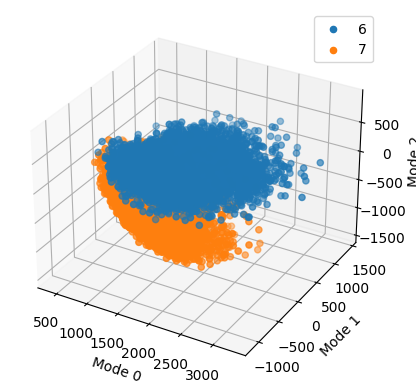

In [21]:
#most accurate (easy to separate) pair: 6 and 7
print3D([0, 1, 2], vt, X, Y, np.array([6, 7]))

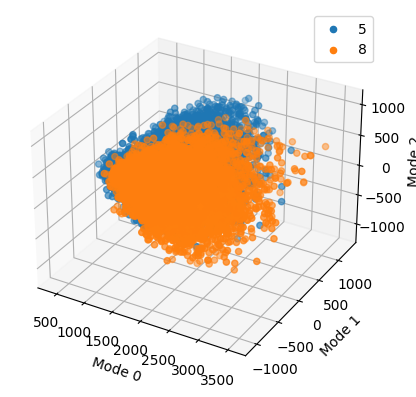

In [22]:
#least accurate pair: 5 and 8
print3D([0, 1, 2], vt, X, Y, np.array([5, 8]))

In [23]:
#3 Digit LDA on digits 4, 6, and 7:

# Select only the data points corresponding to digits 4, 6, and 7
X_subset = X[(Y==4) | (Y==6) | (Y==7)]
Y_subset = Y[(Y==4) | (Y==6) | (Y==7)]

X_train, X_test, Y_train, Y_test = train_test_split(X_subset, Y_subset, test_size=0.2, random_state=42)

# Train an LDA classifier
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, Y_train)

# Evaluate the classifier on the training and test sets
accTrain = clf.score(X_train, Y_train)
accTest = clf.score(X_test, Y_test)
print("Accuracy on training set: {:.2f}%".format(accTrain))
print("Accuracy on test set: {:.2f}%".format(accTest))

Accuracy on training set: 0.98%
Accuracy on test set: 0.98%


In [24]:
#SVM:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a Support Vector Machine classifier with a radial basis function kernel
svm = SVC(kernel='rbf')

# Train the classifier on the training data
svm.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

# Calculate the accuracy of the classifier
accuracyTrain = accuracy_score(y_train, y_pred_train)*100
accuracyTest = accuracy_score(y_test, y_pred_test)*100

print("SVM training accuracy: {:.2f}%".format(accuracyTrain))
print("SVM testing accuracy: {:.2f}%".format(accuracyTest))

SVM training accuracy: 98.99%
SVM testing accuracy: 97.64%


In [25]:
#Decision Tree:

# Create the decision tree classifier object
dtc = DecisionTreeClassifier()

# Train the classifier on the training data
dtc.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

# Calculate the accuracy of the classifier
accuracyTrain = accuracy_score(y_train, y_pred_train)*100
accuracyTest = accuracy_score(y_test, y_pred_test)*100
print("Decision Tree training accuracy: {:.2f}%".format(accuracyTrain))
print("Decision Tree testing accuracy: {:.2f}%".format(accuracyTest))

Decision Tree training accuracy: 100.00%
Decision Tree testing accuracy: 87.11%


In [26]:
def SVMandDT (Xnp, Y, pair):   
    # Extract the data for the two digits
    idx = np.concatenate((np.array(np.where(Y == pair[0]))[0, :], np.array(np.where(Y == pair[1]))[0, :]))
    X_pair = Xnp[idx]
    y_pair = Y[idx]
    y_pair[y_pair == pair[0]] = 0
    y_pair[y_pair == pair[1]] = 1

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_pair, test_size=0.2, random_state=0)

    #SVM:
    # Create a Support Vector Machine classifier with a radial basis function kernel
    svm = SVC(kernel='rbf')

    # Train the classifier on the training data
    svm.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred_train_SVM = svm.predict(X_train)
    y_pred_test_SVM = svm.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy_train_SVM = accuracy_score(y_train, y_pred_train_SVM)*100
    accuracy_test_SVM = accuracy_score(y_test, y_pred_test_SVM)*100

    print("SVM training accuracy: {:.2f}%".format(accuracy_train_SVM))
    print("SVM testing accuracy: {:.2f}%".format(accuracy_test_SVM))

    #Decision Tree:
    # Create the decision tree classifier object
    dtc = DecisionTreeClassifier()

    # Train the classifier on the training data
    dtc.fit(X_train, y_train)

    # Use the trained classifier to make predictions on the test data
    y_pred_train_DT = dtc.predict(X_train)
    y_pred_test_DT = dtc.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy_train_DT = accuracy_score(y_train, y_pred_train_DT)*100
    accuracy_test_DT = accuracy_score(y_test, y_pred_test_DT)*100
    print("Decision Tree training accuracy: {:.2f}%".format(accuracy_train_DT))
    print("Decision Tree testing accuracy: {:.2f}%".format(accuracy_test_DT))

In [27]:
#Compares the accuracies of the three algorithms on the easy to separate pair 6 and 7
print("For easy pair 6 and 7: ")
print("LDA training accuracy: {:.2f}%".format(resultTrainErrors[0]))
print("LDA testing accuracy: {:.2f}%".format(resultTestErrors[0]))
SVMandDT(Xnp, Y, np.array([6, 7]))

For easy pair 6 and 7: 
LDA training accuracy: 99.85%
LDA testing accuracy: 99.75%
SVM training accuracy: 99.99%
SVM testing accuracy: 100.00%
Decision Tree training accuracy: 100.00%
Decision Tree testing accuracy: 99.44%


In [28]:
#Compares the accuracies of the three algorithms on the hard to separate pair 5 and 8
print("For hard pair 5 and 8: ")
print("LDA training accuracy: {:.2f}%".format(resultTrainErrors[44]))
print("LDA testing accuracy: {:.2f}%".format(resultTestErrors[44]))
SVMandDT(Xnp, Y, np.array([5, 8]))

For hard pair 5 and 8: 
LDA training accuracy: 96.73%
LDA testing accuracy: 94.98%
SVM training accuracy: 99.77%
SVM testing accuracy: 99.20%
Decision Tree training accuracy: 100.00%
Decision Tree testing accuracy: 96.00%


There was very little overtraining and very high accuracy for the easy 6 and 7 pair. However, for the harder 5 and 8 pair, the accuracies were still about 95%+, but the LDA and decision tree algorithms overtrained by a small amount, and the accuracies for all of the methods dropped a little bit. The SVM however stayed within 1% from 100% accuracy and proved to be very effective albeit slower than the other algorithms. 